# 1. Libraries

In [ ]:
import numpy as np
import pandas as pd

import xgboost as xgb
import shap
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from autoencoder import Autoencoder, AutoencoderTrainer, autoencoder_workflow

# 2. Data Loading

In [18]:
filepath = "../data/"

train_df = pd.read_parquet(filepath+"train.parquet")
features = train_df.drop('label', axis = 1)
y = train_df['label']
# test_df = pd.read_parquet(filepath+"test.parquet")

# 3. Collinearity Feature Compression
- Collinearity-based feature compression to remove highly correlated and uninformative features
- Inspired by Tony271YnoT's approach
- Baseline filtering by correlation with the target (782 features kept)
- Compress blocks of highly correlated features (threshold 0.6) by selecting a medoid (144 features kept)
- Result: fewer, more informative features for modeling

In [ ]:
def corr_compression(features, y, method="spearman", corr_threshold=0.6, target_threshold=1e-4):

    initial_filtered = [
        col for col in features.columns
        if abs(features[col].corr(y, method=method)) >= target_threshold
    ]
    features = features[initial_filtered].copy()
    print(f"{len(initial_filtered)} features kept after target filtering")

    corr_matrix = features.corr(method=method)

    groups = []
    visited = set()

    for col in corr_matrix.columns:
        if col in visited:
            continue
        group = set(corr_matrix.columns[corr_matrix[col] > corr_threshold])
        groups.append(group)
        visited |= group

    selected_features = []

    for group in groups:
        if len(group) == 1:
            selected_features.extend(group)
            continue

        sub_corr = corr_matrix.loc[list(group), list(group)].copy()
        np.fill_diagonal(sub_corr.values, 0)
        mean_corr = sub_corr.mean(axis=1)
        medoid = mean_corr.idxmax()
        selected_features.append(medoid)

    reduced_df = features[selected_features].copy()
    print(f"{len(selected_features)} features kept after correlation compression")

    return reduced_df

In [8]:
filtered_df = corr_compression(features, y, corr_threshold=0.6, target_threshold=1e-4)

Step 1: 782 features kept after target filtering
Step 2: 144 features kept after correlation compression


# 4. Feature Selection: Function Definition and Initial Run
- Define a baseline feature selection function.  
- Apply time series cross-validation with 6 splits for robust feature evaluation.  
- Use XGBoost to perform cross-validated feature selection in each fold.  
- Extract the top 20 features from each fold and identify the most consistently selected features across folds.  
- Use SHAP values to evaluate and rank feature importance.  

In [ ]:
def cv_shap_feature_selection_timeseries(X, y, n_splits=6, top_k_fold=20, min_folds=2, normalize=True):

    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_top_features = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold+1}/{n_splits}")

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        params = {
            "objective": "reg:squarederror",
            "max_depth": 4,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "n_jobs": -1,
            "eval_metric": "mae"
        }

        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, "eval")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        explainer = shap.TreeExplainer(bst)
        shap_values = explainer.shap_values(X_train)

        mean_shap = np.abs(shap_values).mean(axis=0)
        if normalize:
            mean_shap = mean_shap / mean_shap.sum()

        feature_importance = pd.Series(mean_shap, index=X.columns)
        top_features = feature_importance.nlargest(top_k_fold).index.tolist()
        fold_top_features.append(top_features)

        print(f"Top-{top_k_fold} features for fold {fold+1}:", top_features)

    all_features = [f for fold_list in fold_top_features for f in fold_list]
    feature_counts = pd.Series(all_features).value_counts()

    consistent_features = feature_counts[feature_counts >= min_folds].index.tolist()
    print(f"\nFeatures appearing in ≥{min_folds} folds ({len(consistent_features)} features):", consistent_features)

    return consistent_features, fold_top_features, feature_counts

In [11]:
consistent_features, fold_top_features, feature_counts = cv_shap_feature_selection_timeseries(
    filtered_df, y, n_splits=6, top_k_fold=20, min_folds=2
)


Fold 1/6
Top-20 features for fold 1: ['X294', 'X500', 'X778', 'X777', 'X652', 'X573', 'X204', 'X451', 'X173', 'X447', 'X313', 'X763', 'X377', 'bid_qty', 'ask_qty', 'X8', 'X244', 'X39', 'X18', 'X21']

Fold 2/6
Top-20 features for fold 2: ['X294', 'X21', 'X652', 'X777', 'X550', 'X362', 'X678', 'X573', 'X604', 'X91', 'X84', 'X551', 'X367', 'X763', 'bid_qty', 'ask_qty', 'X8', 'X244', 'X39', 'X18']

Fold 3/6
Top-20 features for fold 3: ['X294', 'X21', 'X752', 'X772', 'X332', 'X758', 'X759', 'X45', 'X39', 'X652', 'X608', 'X367', 'X31', 'X731', 'X287', 'X602', 'X507', 'X500', 'X770', 'X610']

Fold 4/6
Top-20 features for fold 4: ['X21', 'X294', 'X614', 'X699', 'X652', 'X778', 'X332', 'X650', 'X558', 'X550', 'X84', 'X758', 'X125', 'X287', 'bid_qty', 'ask_qty', 'X763', 'X8', 'X244', 'X39']

Fold 5/6
Top-20 features for fold 5: ['X752', 'X614', 'X294', 'X287', 'X678', 'X84', 'X758', 'X550', 'X551', 'X777', 'X486', 'X763', 'bid_qty', 'ask_qty', 'X8', 'X244', 'X39', 'X18', 'X21', 'X31']

Fold 6/6

# 5. Interaction Features
- Generate interaction and polynomial features up to degree 2 using `PolynomialFeatures`.  
- Apply only to the initially selected features from the feature selection step.  
- Expand feature set from 30 to 464 features.  

In [ ]:
X_base = filtered_df[consistent_features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_base)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

feature_names = poly.get_feature_names_out(X_base.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

print("Original features:", X_base.shape[1])
print("Compressed Polynomial features (degree 2):", X_poly_df.shape[1])

Step 1: 0 features kept after target filtering
Step 2: 0 features kept after correlation compression
Original features: 29
Polynomial features (degree 2): 464


In [ ]:
consistent_features, fold_top_features, feature_counts = cv_shap_feature_selection_timeseries(
    X_poly_df, y, n_splits=6, top_k_fold=20, min_folds=1
)


Fold 1/6
Top-20 features for fold 1: ['X294 X652', 'X758 X778', 'X287 X608', 'X500 X173', 'X758 X500', 'X763 X678', 'X652 X678', 'X39 X573', 'X550 X608', 'X332 X573', 'X39 X332', 'X752 X367', 'X652 X31', 'X287 X777', 'X763', 'X652 X332', 'X763^2', 'X652 X84', 'X294 X21', 'X777']

Fold 2/6
Top-20 features for fold 2: ['X294', 'X287 X608', 'X652', 'X500 X173', 'X39 X573', 'X550', 'X294 X31', 'X550 X678', 'X573', 'X614', 'X332 X367', 'X778 X173', 'X21', 'X39', 'X763', 'X244', 'X8', 'ask_qty', 'X758', 'bid_qty']

Fold 3/6
Top-20 features for fold 3: ['X294', 'X21', 'X763 X752', 'X752 X500', 'X752 X759', 'X758 X31', 'X45 X367', 'X39 X332', 'X550', 'X678 X608', 'X294 X45', 'X614', 'X84', 'X778', 'X294 X752', 'X39', 'X652', 'X763', 'X244', 'X8']

Fold 4/6
Top-20 features for fold 4: ['X294', 'X763 X752', 'X614 X500', 'X287 X608', 'X287 X500', 'X39 X678', 'X608 X551', 'X778 X759', 'X294 X778', 'X550', 'X777 X550', 'X678 X551', 'X759 X367', 'X294 X500', 'X21', 'X39', 'X652', 'X763', 'X244', 'X

# 6. Autoencoder Feature Engineering
- Apply an autoencoder to compress features into a dense representation.  
- Input features come from the polynomial feature selection step.  
- Typically observe a noticeable difference between training and validation reconstruction errors.  
- After normalization, mean reconstruction error remains relatively high:  
  - Original shape: `(525,886, 20)`  
  - Encoded shape: `(525,886, 8)`  
  - Mean reconstruction error: `0.440412`

Input dimension: 20
Encoding dimension: 8
Compression ratio: 2.50x
Loss Function: MSE
Starting training...
Epoch [0/200], Train Loss: 0.537038, Val Loss: 2.721084
Epoch [1/200], Train Loss: 0.384628, Val Loss: 2.382279
Epoch [2/200], Train Loss: 0.340179, Val Loss: 2.224463
Epoch [3/200], Train Loss: 0.323805, Val Loss: 2.202197
Epoch [4/200], Train Loss: 0.307901, Val Loss: 2.185341
Epoch [5/200], Train Loss: 0.296377, Val Loss: 2.134848
Epoch [6/200], Train Loss: 0.287918, Val Loss: 2.039731
Epoch [7/200], Train Loss: 0.280303, Val Loss: 2.031105
Epoch [8/200], Train Loss: 0.275522, Val Loss: 1.987834
Epoch [9/200], Train Loss: 0.272936, Val Loss: 1.948570
Epoch [10/200], Train Loss: 0.270713, Val Loss: 1.915514
Epoch [11/200], Train Loss: 0.268331, Val Loss: 1.896286
Epoch [12/200], Train Loss: 0.266719, Val Loss: 1.919432
Epoch [13/200], Train Loss: 0.265240, Val Loss: 1.887303
Epoch [14/200], Train Loss: 0.263543, Val Loss: 1.916908
Epoch [15/200], Train Loss: 0.261965, Val Loss: 

<string>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


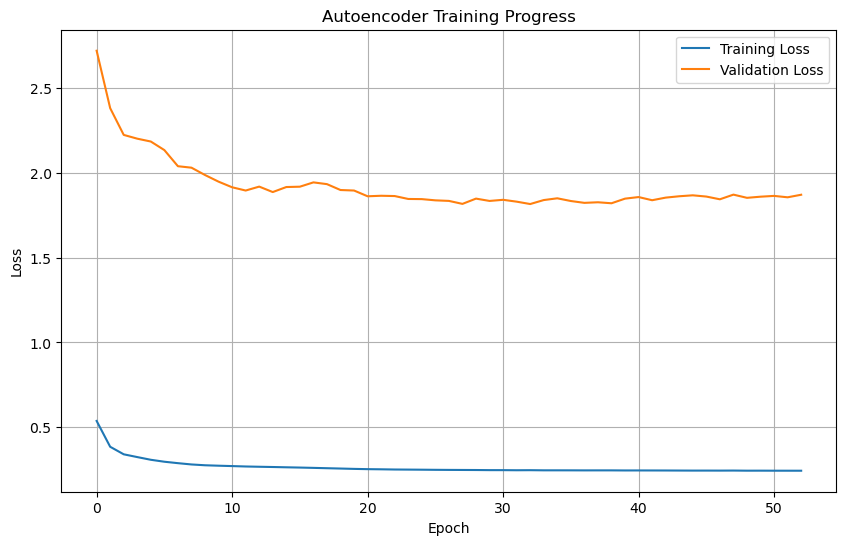

Original shape: (525886, 20)
Encoded shape: (525886, 8)
Mean reconstruction error: 0.440412


In [66]:
autoencoder, encoded_df, reconstruction_error = autoencoder_workflow(X_poly_df[consistent_features], encoding_dim=8, epochs=200)

# 7. Final Feature Selections
- Perform final feature selection using a combination of autoencoder features and polynomial features, applied on the reduced dataframe.  
- End up focusing on a total of `25` features.  
- Save the resulting dataset for use in future modeling.

In [69]:
combined_df = pd.concat([X_poly_df[consistent_features], encoded_df], axis=1)

In [72]:
consistent_features, fold_top_features, feature_counts = cv_shap_feature_selection_timeseries(
    combined_df, y, n_splits=6, top_k_fold=20, min_folds=1
)


Fold 1/6
Top-20 features for fold 1: ['X39', 'X778', 'X287 X608', 'X758 X500', 'X652', 'X777', 'X39 X332', 'X763', 'X39 X573', 'X294', 'X550', 'X614', 'X777 X752', 'X21', 'X8', 'X244', 'X763 X752', 'X758', 'X294 X31', 'X500 X173']

Fold 2/6
Top-20 features for fold 2: ['X294', 'X652', 'X287 X608', 'X758 X500', 'X777', 'X550', 'X39 X332', 'X758', 'X294 X31', 'X614', 'X39 X573', 'X763', 'encoded_feature_6', 'X39', 'X21', 'X8', 'X244', 'X763 X752', 'X777 X752', 'X778']

Fold 3/6
Top-20 features for fold 3: ['X294', 'X287 X608', 'X763 X752', 'X652', 'X758 X500', 'X39 X332', 'X777', 'X550', 'X294 X31', 'X614', 'X777 X752', 'X763', 'X758', 'X39', 'X21', 'X8', 'X244', 'X778', 'X39 X573', 'X500 X173']

Fold 4/6
Top-20 features for fold 4: ['X294', 'X758 X500', 'encoded_feature_6', 'X39', 'X763 X752', 'X287 X608', 'X500 X173', 'encoded_feature_4', 'X21', 'X777 X752', 'X652', 'X614', 'X550', 'X763', 'X39 X332', 'X777', 'X294 X31', 'X758', 'X778', 'X8']

Fold 5/6
Top-20 features for fold 5: ['X7

In [75]:
combined_df[consistent_features].to_parquet("../data/consistent_features.parquet", index=False)

# 9. Summary + Next Steps
- Data was noisy; efforts focused on reducing it to the most informative parts.  
- Used Autoencoder (AE) to capture nonlinear information.  
- Used polynomial interaction features to enrich the dataset.  
- Will use `25` features for future modeling.  
- Future testing may result in data leakage on the training side because code refactoring was likely not performed; focus was primarily on Kaggle test performance.  
- Lack of future signaling might mean that feature selection is overly aggressive.